In [106]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense
from keras.models import Sequential, load_model
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Run this command to import the DataFrame from the other notebook
%store -r combinedInRangeDf

# Load the combined dataframe
#data = pd.read_csv(r'/Users/aaroncao/Documents/California Wildfire Project/combinedInRangeDf.csv')
data = combinedInRangeDf.copy()
print(data.head())

       STATION      AWND  AVG PRECIP  TOTAL PRECIP   AVG SNOW  TOTAL SNOW  \
0  USC00045091  5.363065    0.071429          0.50   0.540722    3.785052   
1  USC00045091  5.363065    0.240000          1.20   8.000000   16.000000   
2  USC00045091  5.363065    0.497143          3.48  13.200000   39.600000   
3  USC00045091  5.363065    0.741429          5.19  11.000000   33.000000   
4  USC00045091  5.309970    0.077143          0.54   0.800000    4.000000   

    AVG TEMP  AVG MAX TEMP  MAX TEMP  AVG MIN TEMP  MIN TEMP      TAVG2  \
0  47.376344     41.714286      50.0     27.142857      16.0  34.428571   
1  47.376344     42.857143      53.0     31.285714      22.0  37.071429   
2  47.376344     35.333333      46.0     11.166667       5.0  23.250000   
3  47.376344     34.857143      40.0      9.285714      -2.0  22.071429   
4  49.581029     53.142857      56.0     24.428571      18.0  38.785714   

   LATITUDE  LONGITUDE  ELEVATION       Begin         End  fire fire arr  
0  33.81299

In [107]:


# Assuming your dataframe is named 'df'
# Combine data from all weather stations
combined_data = data.copy()

combined_data.loc[data['fire'] == 'None', 'fire'] = 0
combined_data.loc[data['fire'] == 'minor', 'fire'] = 1
combined_data.loc[data['fire'] == 'major', 'fire'] = 1
# Shift the target variable to get the target for the next week
combined_data['fire next week'] = combined_data.groupby('STATION')['fire'].shift(-1)

# Drop the last row with NaN target since there is no target for it
combined_data = combined_data.dropna()

# Define the size of the rolling window
#window_size = 7  # Number of previous weeks to consider
window_size = 10

features = ['AWND', 'AVG PRECIP', 'TOTAL PRECIP','AVG SNOW','TOTAL SNOW','AVG TEMP','AVG MAX TEMP','MAX TEMP','AVG MIN TEMP','MIN TEMP','LATITUDE','LONGITUDE','ELEVATION']
target = 'fire next week'

# Split data into features and target
X = combined_data[features]  # Features
y = combined_data[target]     # Target

# Apply rolling window to create sequences of inputs and targets
X_rolling = []
y_rolling = []
for i in range(len(X) - window_size + 1):
    X_rolling.append(X.iloc[i:i+window_size].values.flatten())
    y_rolling.append(y.iloc[i+window_size-1])

# Convert to numpy arrays
X_rolling = pd.DataFrame(X_rolling)
y_rolling = pd.Series(y_rolling)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_rolling, y_rolling, test_size=0.2, shuffle=False)

# Create and train the Random Forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict_proba(X_test)[:, 1] #probability output which needs to be classified into binary
default_pred = (y_pred >= 0.5).astype(int)
default_accuracy = accuracy_score(y_test, default_pred)
print(f"Accuracy: {default_accuracy}")

#new
#dt1 = 0.02
#dt2 = 0.05
#y_pred_probs = model.predict_proba(X_test)[:, 1]
#print(y_pred_probs)
#for j in range(len(y_pred_probs)): # doesnt work
#    if y_pred_probs[j]>=dt2:
#        y_pred_probs[j]==2
#    elif y_pred_probs[j]>=dt1:
#        y_pred_probs[j]==1
#    else:
#        y_pred_probs[j] = 0   
#print(y_pred_probs)
#score = accuracy_score(y_test, y_pred_probs)
#print(f"Accuracy:", score)
#cfmatrix = confusion_matrix(y_test, y_pred_probs)
#groupcounts = ['{0:0.0f}'.format(value) for value in cfmatrix.flatten()]
#grouppercentages = ['{0:.2%}'.format(value) for value in cfmatrix.flatten()/np.sum(cfmatrix)]
#labels = [f'{v1}\n{v2}' for v1, v2 in zip(groupcounts,grouppercentages)]
#labels = np.asarray(labels).reshape(3,3)
##sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
#sns.heatmap(cfmatrix, annot=labels, fmt='', cmap='Blues')


Accuracy: 0.952300785634119


/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics

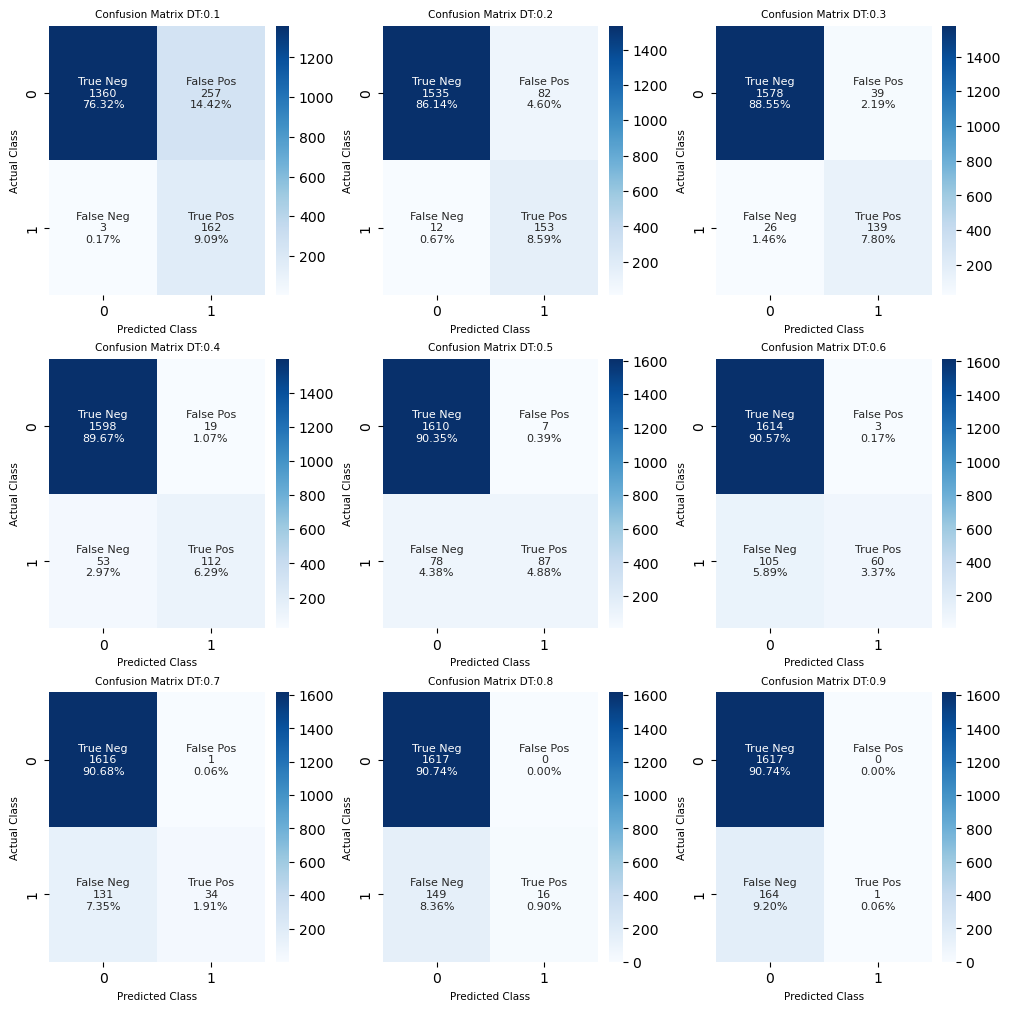

<AxesSubplot:xlabel='DecisionThreshold'>

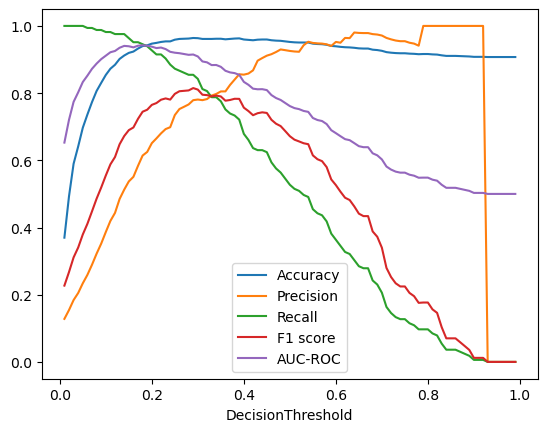

In [108]:
# Convert predictions to binary values (0 or 1)


fig, ax = plt.subplots(3,3, constrained_layout = True, figsize=(10,10))
#sns.heatmap(uniform_data, ax=ax1)
#sns.heatmap(uniform_data2, ax=ax2)
#plt.show()

#y_pred = model.predict(normed_test_data)
#y_pred ... X_test

decisionThresholdArr = np.zeros(shape=(99,6), dtype=float) #float is less storage than double?

for i in range(99):

    decision_threshold = (i+1)/100
    binary_test_prediction_array=(y_pred >= decision_threshold).astype(int)

    precision=precision_score(y_test, binary_test_prediction_array)
    recall = recall_score(y_test, binary_test_prediction_array) #PRIORITIZE RECALL!!!!!
    f1 = f1_score(y_test, binary_test_prediction_array)
    auc_roc = roc_auc_score(y_test, binary_test_prediction_array)
    accuracy = accuracy_score(y_test, binary_test_prediction_array)
    
    decisionThresholdArr[i, 0]= decision_threshold
    decisionThresholdArr[i, 1]= accuracy
    decisionThresholdArr[i, 2]= precision
    decisionThresholdArr[i, 3]= recall
    decisionThresholdArr[i, 4]= f1
    decisionThresholdArr[i, 5]= auc_roc

    #print('Decision Threshold:', decision_threshold)
    if (((i+1)%10)==0): 
        #1 2 3 4 5 6 7 8 9
        #0 0 1 1 1 2 2 2 3
        ind = int(i/10)
        
        cf_matrix = confusion_matrix(y_test, binary_test_prediction_array)
        group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        #sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
        sns.heatmap(cf_matrix, annot=labels, annot_kws={"fontsize":8}, fmt='', cmap='Blues', ax=ax[int(ind/3)][ind%3])
        ax[int(ind/3)][ind%3].set_xlabel('Predicted Class', fontsize=7.5)
        ax[int(ind/3)][ind%3].set_ylabel('Actual Class', fontsize=7.5)
        title = 'Confusion Matrix DT:'+ str(decision_threshold)
        ax[int(ind/3)][ind%3].set_title(title, size=7.5)

    #print('Accuracy:', accuracy)
    #print('Precision:', precision)
    #print('Recall:', recall)
    #print('F1 score:', f1)
    #print('AUC-ROC:', auc_roc)
    #print('----------------------------------------')


plt.show()
    
#y_pred = (y_pred > 0.5).astype(int)

decisionThresholdDf = pd.DataFrame(decisionThresholdArr, columns=['DecisionThreshold', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC-ROC'])
decisionThresholdDf.plot(x='DecisionThreshold', y=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC-ROC'])


best decision threshold 0.25
accuracy 0.9595959595959596
precision 0.7313432835820896
recall 0.8909090909090909
f1 0.8032786885245902
auc_roc 0.9287569573283858


<AxesSubplot:>

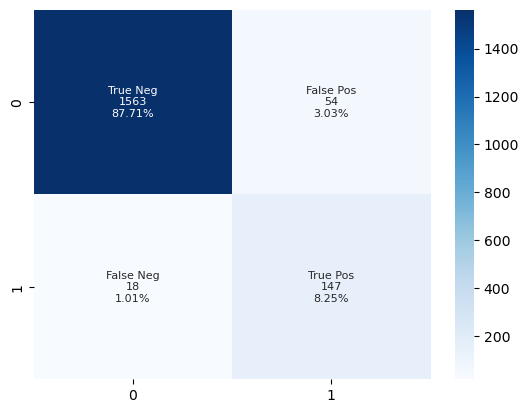

In [105]:

best_decision_threshold = 0.25
best_binary_test_prediction_array=(y_pred >= best_decision_threshold).astype(int)
print('best decision threshold', best_decision_threshold)
print('accuracy', accuracy_score(y_test, best_binary_test_prediction_array))
print('precision',precision_score(y_test, best_binary_test_prediction_array))
print('recall', recall_score(y_test, best_binary_test_prediction_array)) #PRIORITIZE RECALL!!!!!
print('f1', f1_score(y_test, best_binary_test_prediction_array))
print('auc_roc', roc_auc_score(y_test, best_binary_test_prediction_array))
best_cf_matrix = confusion_matrix(y_test, best_binary_test_prediction_array)
best_group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
best_group_counts = ['{0:0.0f}'.format(value) for value in best_cf_matrix.flatten()]
best_group_percentages = ['{0:.2%}'.format(value) for value in best_cf_matrix.flatten()/np.sum(best_cf_matrix)]
best_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(best_group_names,best_group_counts,best_group_percentages)]
best_labels = np.asarray(best_labels).reshape(2,2)
#sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
sns.heatmap(best_cf_matrix, annot=best_labels, annot_kws={"fontsize":8}, fmt='', cmap='Blues')



Accuracy: 0.9906804401527061
Precision: 0.9146005509641874
Recall: 0.9693430656934306
F1 score: 0.9411764705882354
AUC-ROC: 0.9809007020475424


<AxesSubplot:>

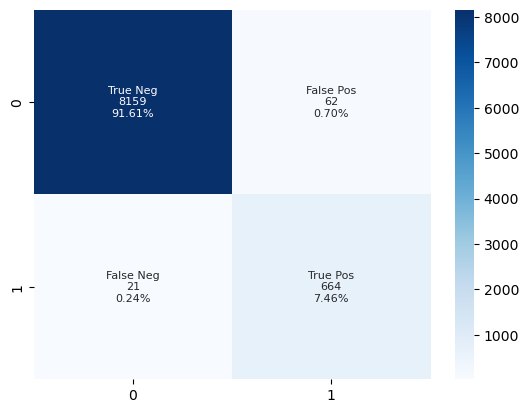

In [111]:
#pred for total data

total_pred = model.predict_proba(X_rolling)[:, 1]
bin_total_pred = (total_pred >= 0.25).astype(int)
total_accuracy = accuracy_score(y_rolling, bin_total_pred)
total_precision=precision_score(y_rolling, bin_total_pred)
total_recall = recall_score(y_rolling, bin_total_pred) #PRIORITIZE RECALL!!!!!
total_f1 = f1_score(y_rolling, bin_total_pred)
total_auc_roc = roc_auc_score(y_rolling, bin_total_pred)
print('Accuracy:', total_accuracy)
print('Precision:', total_precision)
print('Recall:', total_recall)
print('F1 score:', total_f1)
print('AUC-ROC:', total_auc_roc)

cf_matrix = confusion_matrix(y_rolling, bin_total_pred)
group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, annot_kws={"fontsize":8}, fmt='', cmap='Blues')


0    8258
1     595
2      90
Name: fire, dtype: int64
Accuracy: 0.9455667789001122
Precision: [0.98074534 0.66455696 0.07142857]
Recall: [0.97649969 0.73426573 0.04545455]
F1 score: [0.97861791 0.69767442 0.05555556]


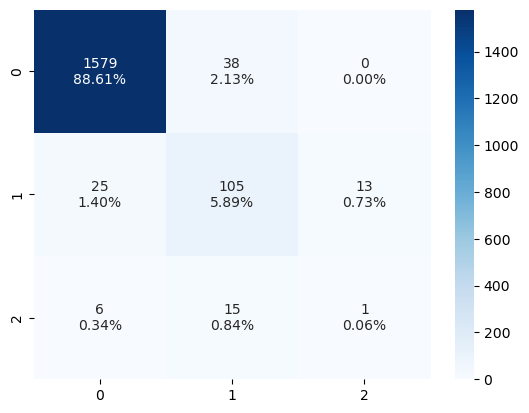

In [139]:
#HORRIBLE WHEN CLASSIFYING MAJOR


combined_data_v2 = data.copy()
combined_data_v2.loc[data['fire'] == 'None', 'fire'] = 0
combined_data_v2.loc[data['fire'] == 'minor', 'fire'] = 1
combined_data_v2.loc[data['fire'] == 'major', 'fire'] = 2

print(combined_data_v2['fire'].value_counts())

# Shift the target variable to get the target for the next week
combined_data_v2['fire next week'] = combined_data_v2.groupby('STATION')['fire'].shift(-1)

# Drop the last row with NaN target since there is no target for it
combined_data_v2 = combined_data_v2.dropna()

# Define the size of the rolling window
#window_size = 7  # Number of previous weeks to consider
window_size2 = 10

features2 = ['AWND', 'AVG PRECIP', 'TOTAL PRECIP','AVG SNOW','TOTAL SNOW','AVG TEMP','AVG MAX TEMP','MAX TEMP','AVG MIN TEMP','MIN TEMP','LATITUDE','LONGITUDE','ELEVATION']
target2 = 'fire next week'

# Split data into features and target
X = combined_data_v2[features2]  # Features
y = combined_data_v2[target2]     # Target

# Apply rolling window to create sequences of inputs and targets
X_rolling2 = []
y_rolling2 = []
for i in range(len(X) - window_size + 1):
    X_rolling2.append(X.iloc[i:i+window_size2].values.flatten())
    y_rolling2.append(y.iloc[i+window_size2-1])

# Convert to numpy arrays
X_rolling2 = pd.DataFrame(X_rolling2)
y_rolling2 = pd.Series(y_rolling2)

# Split data into train and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_rolling2, y_rolling2, test_size=0.2, shuffle=False)

# Create and train the Random Forest classifier
model2 = RandomForestClassifier()
model2.fit(X_train2, y_train2)

# Evaluate the model on the test set


#new
y_pred_probs = model.predict_proba(X_test2)

threshold_1 = 0.2
threshold_2 = 0.7

# Apply the adjusted thresholds and assign class labels


y_pred_adjusted = np.zeros(y_pred_probs.shape[0], dtype=int)
y_pred_adjusted[np.where(y_pred_probs[:, 1] >= threshold_2)] = 2
y_pred_adjusted[np.where((y_pred_probs[:, 0] >= threshold_1) & (y_pred_probs[:, 0] < threshold_2))] = 1


cfmatrix2 = confusion_matrix(y_test2, y_pred_adjusted)
groupcounts2 = ['{0:0.0f}'.format(value) for value in cfmatrix2.flatten()]
grouppercentages2 = ['{0:.2%}'.format(value) for value in cfmatrix2.flatten()/np.sum(cfmatrix2)]
labels2 = [f'{v1}\n{v2}' for v1, v2 in zip(groupcounts2,grouppercentages2)]
labels2 = np.asarray(labels2).reshape(3,3)
sns.heatmap(cfmatrix2, annot=labels2, fmt='', cmap='Blues')

total_accuracy2 = accuracy_score(y_test2, y_pred_adjusted)
total_precision2=precision_score(y_test2, y_pred_adjusted, average=None)
total_recall2 = recall_score(y_test2, y_pred_adjusted, average=None) #PRIORITIZE RECALL!!!!!
total_f12 = f1_score(y_test2, y_pred_adjusted, average=None)

y_true = np.array(y_test2) #true labels
auc_scores = []

print('Accuracy:', total_accuracy2)
print('Precision:', total_precision2)
print('Recall:', total_recall2)
print('F1 score:', total_f12)
#print('AUC-ROC:', auc_scores)
